<h3 style="text-align: center">MNIST dataset training (III)</h3>
<h4 style="text-align: center">Accuracy: training vs test data sets</h4>

In [1]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                transforms.Normalize((0.5,), (0.5,)),
                               ])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [2]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [4]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using:",device)
#device="cpu"


epochs = 10   #30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    print(e)
    running_loss = 0
    
    model.to(device)

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            
            model.to('cpu')
            images, labels = images.to('cpu'), labels.to('cpu')
            
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

using: cuda
0
Epoch: 1/10..  Training Loss: 0.519..  Test Loss: 0.436..  Test Accuracy: 0.840
1
Epoch: 2/10..  Training Loss: 0.396..  Test Loss: 0.418..  Test Accuracy: 0.842
2
Epoch: 3/10..  Training Loss: 0.356..  Test Loss: 0.394..  Test Accuracy: 0.864
3
Epoch: 4/10..  Training Loss: 0.337..  Test Loss: 0.375..  Test Accuracy: 0.865
4
Epoch: 5/10..  Training Loss: 0.317..  Test Loss: 0.366..  Test Accuracy: 0.871
5
Epoch: 6/10..  Training Loss: 0.304..  Test Loss: 0.392..  Test Accuracy: 0.862
6
Epoch: 7/10..  Training Loss: 0.289..  Test Loss: 0.351..  Test Accuracy: 0.878
7
Epoch: 8/10..  Training Loss: 0.284..  Test Loss: 0.390..  Test Accuracy: 0.869
8
Epoch: 9/10..  Training Loss: 0.272..  Test Loss: 0.371..  Test Accuracy: 0.874
9
Epoch: 10/10..  Training Loss: 0.265..  Test Loss: 0.379..  Test Accuracy: 0.870


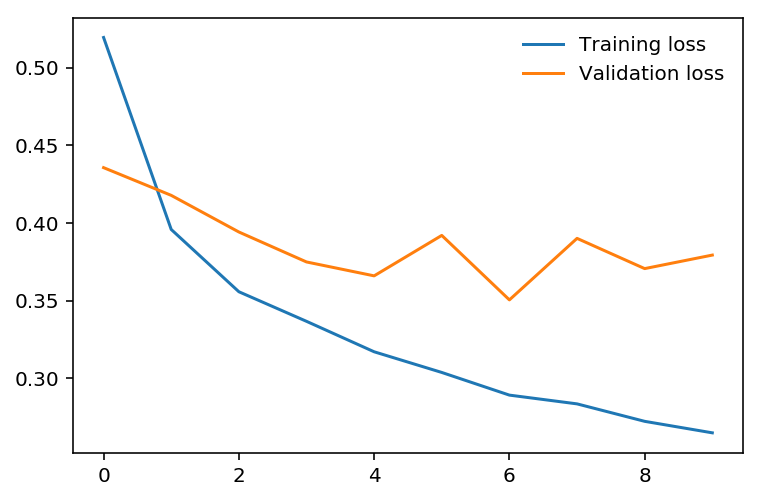

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

see part 5

In [10]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [11]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):

    model.to(device)
    running_loss = 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.to('cpu')
            images, labels = images.to('cpu'), labels.to('cpu')            
            
            model.eval()
            for images, labels in testloader:               
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.605..  Test Loss: 0.468..  Test Accuracy: 0.830
Epoch: 2/30..  Training Loss: 0.477..  Test Loss: 0.478..  Test Accuracy: 0.827
Epoch: 3/30..  Training Loss: 0.451..  Test Loss: 0.407..  Test Accuracy: 0.853
Epoch: 4/30..  Training Loss: 0.432..  Test Loss: 0.410..  Test Accuracy: 0.855
Epoch: 5/30..  Training Loss: 0.420..  Test Loss: 0.393..  Test Accuracy: 0.860
Epoch: 6/30..  Training Loss: 0.409..  Test Loss: 0.411..  Test Accuracy: 0.856
Epoch: 7/30..  Training Loss: 0.409..  Test Loss: 0.396..  Test Accuracy: 0.861
Epoch: 8/30..  Training Loss: 0.400..  Test Loss: 0.400..  Test Accuracy: 0.864
Epoch: 9/30..  Training Loss: 0.398..  Test Loss: 0.433..  Test Accuracy: 0.850
Epoch: 10/30..  Training Loss: 0.390..  Test Loss: 0.380..  Test Accuracy: 0.865
Epoch: 11/30..  Training Loss: 0.381..  Test Loss: 0.385..  Test Accuracy: 0.868
Epoch: 12/30..  Training Loss: 0.377..  Test Loss: 0.400..  Test Accuracy: 0.861
Epoch: 13/30..  Training Loss: 0.377.

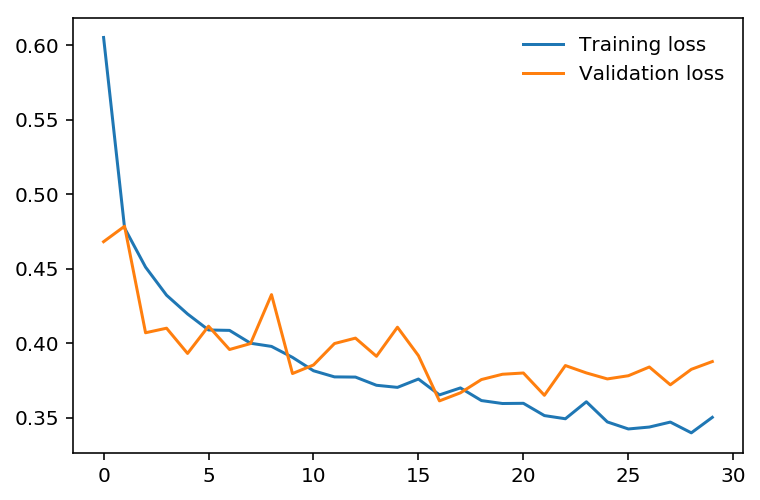

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [13]:
#model.state_dict().keys()
torch.save(model.state_dict(), 'checkpoint1-dropout.pth')

In [ ]:
#state_dict = torch.load('checkpoint1-dropout.pth')
#print(state_dict.keys())
#model.load_state_dict(state_dict)

Test

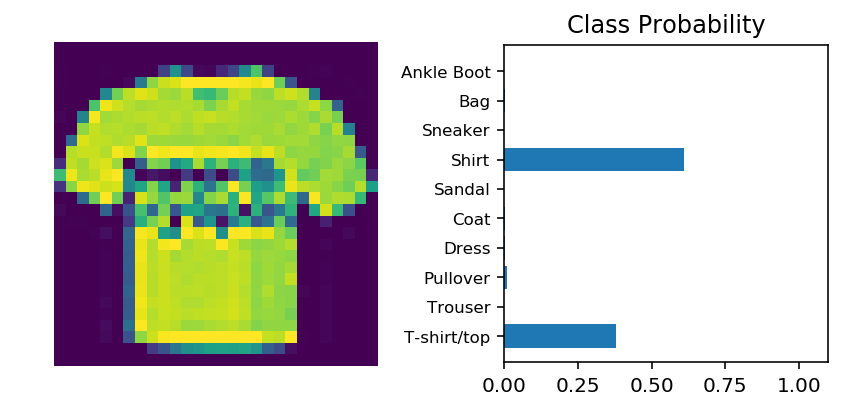

In [14]:
# Import helper module (should be in the repo)
import helper

# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')

<p>Reference:</p>
    
<a href='https://www.udacity.com/course/deep-learning-pytorch--ud188'>Udacity: Intro to deep learning with PyTorch</a>